In [59]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_files
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import string, re, glob, os
nlp = spacy.load("en_core_web_sm")

MATH_LABEL = 0
PAINT_LABEL = 1
DATA_DIR = "data_files/"

### Data loading

In [58]:
cats = ["mathematician", "painter"]
chain = "|".join(cats)
regex = "(.*)_({})".format(chain)
r = re.compile(regex)
namecat = [ [f, r.match(f).group(2)]  for f in glob.glob1("./data_files", "*.txt")]

In [60]:
# Reorganize data into category folders
all_files = glob.glob(os.path.join(DATA_DIR, "*.txt"))
for filename in all_files:
    os.rename(filename, os.path.join(DATA_DIR, r.match(filename).group(2), os.path.basename(filename)))

In [92]:
# Load data from folders into a df, each row is an article
def load_data():
    data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace")
    df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
    return df

df = load_data()


In [93]:
def remove_highlights(row):
    reg = re.compile('(==(.*?)==)')
    row = re.sub(reg, ' ', row)
    return row

# remove spaces, breaklines, tabs
def pre_norm(row):
    return re.sub(r"[\n\t\s]+", " ", row)

In [94]:
df1 = df
df1["text"] = df1["text"].apply(remove_highlights)
df1["text"] = df1["text"].apply(pre_norm)

In [96]:

df1["nlp"] = df1["text"].apply(nlp)

### Tokenization (sentences & tokens)

In [97]:
def tokenize(row):
    tokens = []
    for sent in row.sents:
        sentence = []
        for token in sent:
            sentence.append(token)
        tokens.append(sentence)
    return tokens

def is_latin(word):
    return all(ord(c) < 128 for c in word)

def normalize(row, rm_stops=True, eng_only=True):
    trs = str.maketrans('', '', string.punctuation)
    return [[t.text.translate(trs).lower() for t in sentence if (not t.is_stop and rm_stops) or not rm_stops]  for sentence in row]

In [98]:
df1["sents"] = df1["nlp"].apply(tokenize)

In [182]:
print("Number of sentences: ", sum(df1["sents"].apply(lambda x : len(x))))

Number of sentences:  33862


### Normalisation

In [132]:
df1["norm"] = df1["sents"].apply(normalize)

In [133]:
def rm_empty(row):
    new_row = []
    for sublist in row:
        sl = [x for x in sublist if x]
        if len(sl) != 0:
            new_row.append(sl)
    return new_row

df1["norm"] = df1["norm"].apply(rm_empty)

In [100]:
df1["norm_with_stops"] = df1["sents"].apply(normalize, rm_stops=False)

In [101]:
# remove empty words
df1["norm"] = df1["norm"].apply(lambda x: [[re.sub(r'[\s+|\n+]', ' ', word).strip() for word in sublist if word.strip() != ""] for sublist in x])
df1["norm"] = df1["norm"].apply(lambda x: [[word for word in sublist if is_latin(word) ] for sublist in x])

In [139]:
# remove empty words
df1["norm_with_stops"] = df1["norm_with_stops"].apply(lambda x: [[re.sub(r'\s+', ' ', word).strip() for word in sublist if word.strip() != ""] for sublist in x])
df1["norm_with_stops"] = df1["norm"].apply(rm_empty)
df1["norm_with_stops"] = df1["norm_with_stops"].apply(lambda x: [[word for word in sublist if is_latin(word) ] for sublist in x])

### Average sentence lengths

<AxesSubplot:title={'center':'avg_sent_len'}, xlabel='label'>

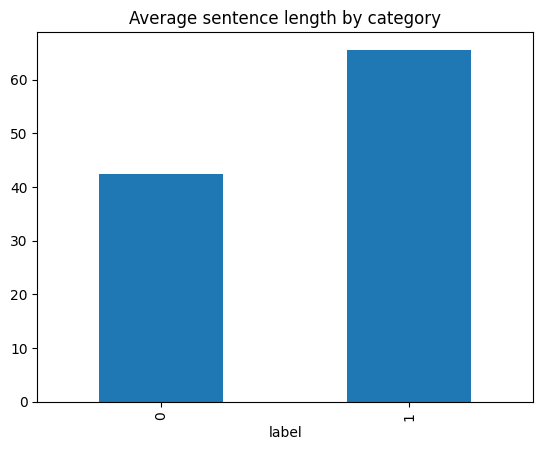

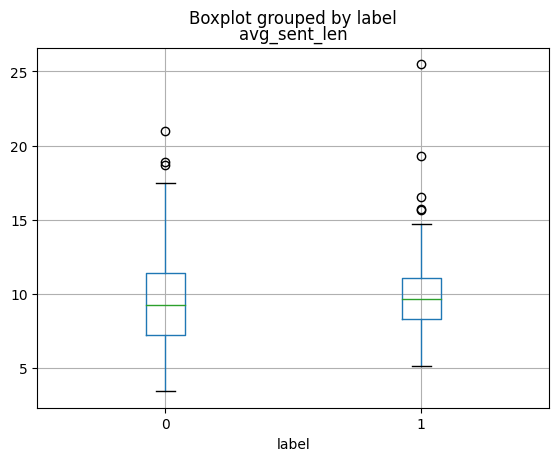

In [141]:
def avg_sentence_length(row):
    return sum(len(sublist) for sublist in row["norm"]) / len(row["norm"])

avg_sent = df1.groupby("label").apply(avg_sentence_length)
avg_sent.plot(kind='bar', title="Average sentence length by category")

df1["avg_sent_len"] = df1.apply(avg_sentence_length, axis=1)
df1.boxplot(by="label", column="avg_sent_len")

### Min-Max sentence lengths

In [142]:
def min_sentence_length(row):
    return np.min([len(sublist) for sublist in row["norm"]])

def max_sentence_length(row):
    return np.max([len(sublist) for sublist in row["norm"]])

df1["min_sent_len"] = df1.apply(min_sentence_length, axis=1)
df1["max_sent_len"] = df1.apply(max_sentence_length, axis=1)

In [143]:
print("Minimum sentence length across all categories", df1["min_sent_len"].min())
print("Minimum sentence length per category", df1.groupby("label")["min_sent_len"].min())

print("Maximum sentence length across all catageories", df1["max_sent_len"].max())
print("Maximum sentence length per category", df1.groupby("label")["max_sent_len"].max())

Minimum sentence length across all categories 1
Minimum sentence length per category label
0    1
1    1
Name: min_sent_len, dtype: int64
Maximum sentence length across all catageories 134
Maximum sentence length per category label
0    134
1    100
Name: max_sent_len, dtype: int64


### Token occurences

In [144]:
# word freq by sentences
df1["counter"] = df1["norm"].apply(lambda x: [Counter(sublist) for sublist in x])

In [145]:
df1["counter_w_stops"] = df1["norm_with_stops"].apply(lambda x: [Counter(sublist) for sublist in x])

In [146]:
# unroll each sentence into a row
df_count = df1[["counter", "label"]].explode("counter")

In [147]:
# Set index based on article, assigning a number to each sentence 
df_count['sent_nb'] = df_count.groupby(['label']).cumcount()+1

In [148]:
df_count

,counter,label,sent_nb
0,"{'knud': 1, 'agger': 1, '26': 1, 'september': ...",1,1
0,"{'series': 1, 'paintings': 1, 'everyday': 1, '...",1,2
0,"{'time': 1, 'work': 1, 'took': 1, 'visionary':...",1,3
0,"{'knud': 1, 'agger': 1, 'originally': 1, 'hols...",1,4
0,"{'returned': 1, 'native': 1, 'region': 1, '192...",1,5
...,...,...,...
666,"{'online': 1, 'edition': 1, 'httpnbnresolvingd...",1,13368
666,"{'rachel': 1, 'dickson': 1, 'adler': 1, 'żuław...",1,13369
666,"{'jankel': 1, 'adler': 1, 'collection': 1, 'is...",1,13370
666,"{'retrieved': 1, 'september': 1, '2016': 1}",1,13371


#### Min/max/avg number of token occurrences per sentence per category.

In [149]:
df_count["avg_tok_occ"] = df_count["counter"].apply(lambda x: np.mean(list(x.values())))
df_count["min_tok_occ"] = df_count["counter"].apply(lambda x: np.min(list(x.values())))
df_count["max_tok_occ"] = df_count["counter"].apply(lambda x: np.max(list(x.values())))

In [150]:
df_count

,counter,label,sent_nb,avg_tok_occ,min_tok_occ,max_tok_occ
0,"{'knud': 1, 'agger': 1, '26': 1, 'september': ...",1,1,1.000000,1,1
0,"{'series': 1, 'paintings': 1, 'everyday': 1, '...",1,2,1.000000,1,1
0,"{'time': 1, 'work': 1, 'took': 1, 'visionary':...",1,3,1.000000,1,1
0,"{'knud': 1, 'agger': 1, 'originally': 1, 'hols...",1,4,1.066667,1,2
0,"{'returned': 1, 'native': 1, 'region': 1, '192...",1,5,1.000000,1,1
...,...,...,...,...,...,...
666,"{'online': 1, 'edition': 1, 'httpnbnresolvingd...",1,13368,1.000000,1,1
666,"{'rachel': 1, 'dickson': 1, 'adler': 1, 'żuław...",1,13369,1.000000,1,1
666,"{'jankel': 1, 'adler': 1, 'collection': 1, 'is...",1,13370,1.000000,1,1
666,"{'retrieved': 1, 'september': 1, '2016': 1}",1,13371,1.000000,1,1


#### Total number of tokens by category 


In [168]:
# Total number of tokens  
print("Number of tokens (with stop words and NO normalization) :", sum(df1["nlp"].apply(lambda x : len(x))))
print("Number of tokens (NO stop words and normalization) :", sum(df1["norm"].apply(lambda x : sum(len(s) for s in x))))
print("Number of tokens (stop words and normalization) :", sum(df1["norm_with_stops"].apply(lambda x : sum(len(s) for s in x))))

# for mathematicians
print("For Mathematicians")
print("Number of tokens (with stop words and NO normalization) :", sum(df1[df1["label"]==MATH_LABEL]["nlp"].apply(lambda x : len(x))))
print("Number of tokens (NO stop words and normalization) :", sum(df1[df1["label"]==MATH_LABEL]["norm"].apply(lambda x : sum(len(s) for s in x))))
print("Number of tokens (stop words and normalization) :", sum(df1[df1["label"]==MATH_LABEL]["norm_with_stops"].apply(lambda x : sum(len(s) for s in x))))

# for painters
print("For Painters")
print("Number of tokens (with stop words and NO normalization) :", sum(df1[df1["label"]==PAINT_LABEL]["nlp"].apply(lambda x : len(x))))
print("Number of tokens (NO stop words and normalization) :", sum(df1[df1["label"]==PAINT_LABEL]["norm"].apply(lambda x : sum(len(s) for s in x))))
print("Number of tokens (stop words and normalization) :", sum(df1[df1["label"]==PAINT_LABEL]["norm_with_stops"].apply(lambda x : sum(len(s) for s in x))))

Number of tokens (with stop words and NO normalization) : 619278
Number of tokens (NO stop words and normalization) : 307105
Number of tokens (NO stop words and normalization) : 298290
For Mathematicians
Number of tokens (with stop words and NO normalization) : 337893
Number of tokens (NO stop words and normalization) : 168644
Number of tokens (NO stop words and normalization) : 162815
For Painters
Number of tokens (with stop words and NO normalization) : 281385
Number of tokens (NO stop words and normalization) : 138461
Number of tokens (NO stop words and normalization) : 135475


In [200]:
df2["nbr_tok_nstop"] = df2["norm"].apply(lambda x : sum(len(s) for s in x))
df2.groupby("label")["nbr_tok_nstop"].sum()

label
0    168644
1    138461
Name: nbr_tok_nstop, dtype: int64

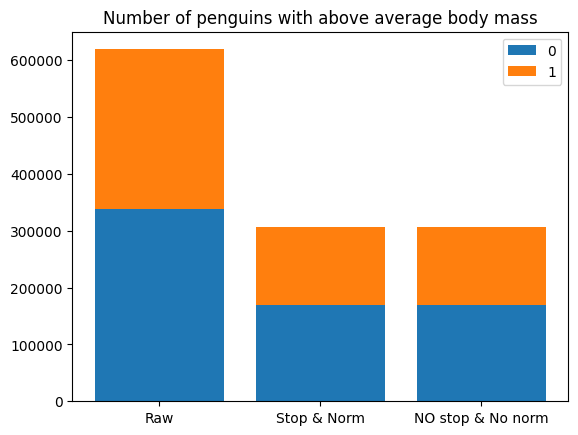

In [204]:
df2 = df1
df2["nbr_tok"] = df2["nlp"].apply(lambda x : len(x))
raw_tok = df2.groupby("label")["nbr_tok"].sum()

df2["nbr_tok_nstop"] = df2["norm"].apply(lambda x : sum(len(s) for s in x))
nstop = df2.groupby("label")["nbr_tok_nstop"].sum()

df2["nbr_tok_stop_norm"] = df2["norm"].apply(lambda x : sum(len(s) for s in x))
stop_norm = df2.groupby("label")["nbr_tok_stop_norm"].sum()

treat = ["Raw", "Stop & Norm", "NO stop & No norm"]


weight_counts = {
    "0": [raw_tok[0], stop_norm[0],nstop[0]],
    "1": [raw_tok[1], stop_norm[1],nstop[1]]
}

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(treat, weight_count, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

plt.show()

In [197]:
df2.groupby("label")["nbr_tok"].sum()[0]

337893

### Most common tokens by category

In [153]:
# Token occurence per category
mathematicians = sum((tuple(sum(df1[df1["label"]==MATH_LABEL]["counter"], []))), Counter())
painters = sum((tuple(sum(df1[df1["label"]==PAINT_LABEL]["counter"], []))), Counter())

In [154]:
mathematicians_wstop = sum((tuple(sum(df1[df1["label"]==MATH_LABEL]["counter_w_stops"], []))), Counter())
painters_wstop = sum((tuple(sum(df1[df1["label"]==PAINT_LABEL]["counter_w_stops"], []))), Counter())

In [155]:
print("Most common tokens for mathematician category :", mathematicians.most_common(10))
print("Most common tokens for painter category :", painters.most_common(10))

Most common tokens for mathematician category : [('university', 1782), ('mathematics', 1421), ('mathematical', 840), ('theory', 722), ('–', 623), ('professor', 547), ('work', 529), ('society', 491), ('de', 461), ('american', 460)]
Most common tokens for painter category : [('art', 1578), ('painting', 699), ('work', 596), ('new', 587), ('paintings', 556), ('artists', 551), ('works', 546), ('museum', 465), ('gallery', 366), ('painter', 363)]


<BarContainer object of 10 artists>

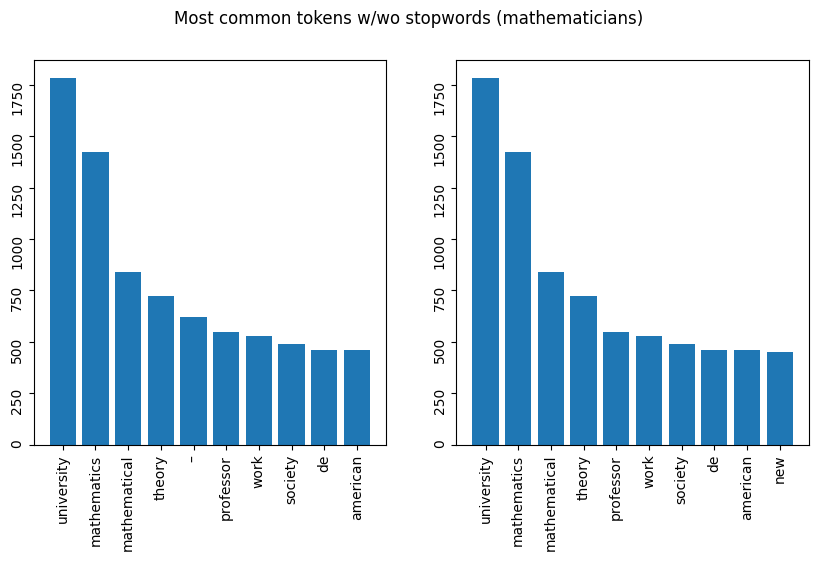

In [156]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common tokens w/wo stopwords (mathematicians)')
ax1.bar(*zip(*mathematicians.most_common(10)))
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*mathematicians_wstop.most_common(10)))

<BarContainer object of 10 artists>

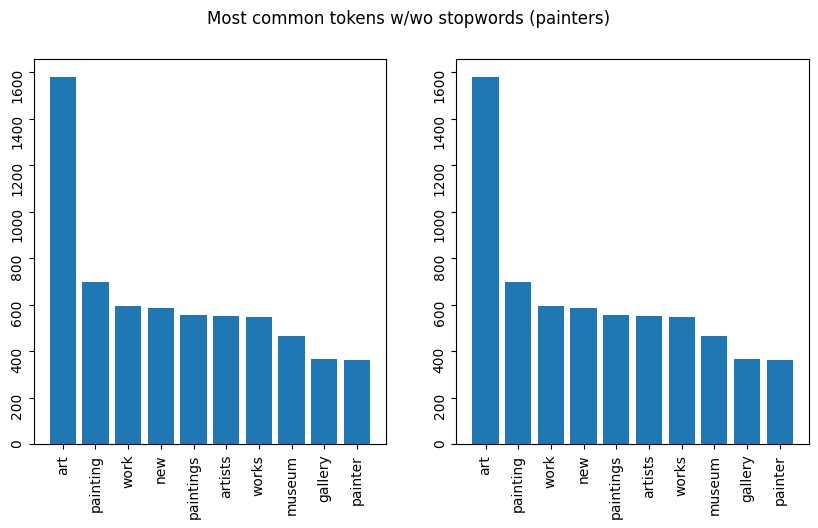

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common tokens w/wo stopwords (painters)')
ax1.bar(*zip(*painters.most_common(10)))
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*painters_wstop.most_common(10)))

### 50 Most common words 

In [158]:
print("Most common 50 words (mathematicians) :")
print("With stopwords :")
print(mathematicians_wstop.most_common(50))
print("Without stopwords :")
print(mathematicians.most_common(50))

Most common 50 words (mathematicians) :
With stopwords :
[('university', 1782), ('mathematics', 1421), ('mathematical', 840), ('theory', 722), ('professor', 547), ('work', 529), ('society', 491), ('de', 461), ('american', 460), ('new', 452), ('mathematician', 451), ('science', 446), ('research', 433), ('isbn', 418), ('born', 392), ('school', 377), ('sciences', 370), ('1', 369), ('known', 360), ('institute', 353), ('book', 315), ('time', 312), ('college', 302), ('years', 289), ('john', 283), ('j', 282), ('member', 279), ('academy', 278), ('works', 276), ('later', 271), ('physics', 271), ('analysis', 268), ('aristotle', 267), ('a', 265), ('2', 265), ('published', 265), ('3', 263), ('0', 256), ('geometry', 247), ('phd', 242), ('history', 240), ('received', 239), ('york', 228), ('c', 228), ('fellow', 222), ('department', 220), ('journal', 217), ('al', 217), ('problem', 215), ('prize', 214)]
Without stopwords :
[('university', 1782), ('mathematics', 1421), ('mathematical', 840), ('theory', 

In [159]:
print("Most common 50 words (painters) :")
print("With stopwords :")
print(painters_wstop.most_common(50))
print("Without stopwords :")
print(painters.most_common(50))

Most common 50 words (painters) :
With stopwords :
[('art', 1578), ('painting', 699), ('work', 596), ('new', 587), ('paintings', 556), ('artists', 551), ('works', 546), ('museum', 465), ('gallery', 366), ('painter', 363), ('artist', 359), ('century', 349), ('school', 335), ('arts', 324), ('london', 320), ('isbn', 313), ('world', 306), ('time', 303), ('later', 286), ('known', 276), ('york', 269), ('exhibition', 267), ('including', 266), ('early', 257), ('audubon', 257), ('years', 256), ('style', 254), ('de', 254), ('life', 248), ('paris', 244), ('american', 241), ('group', 240), ('history', 234), ('born', 232), ('e', 230), ('painted', 224), ('university', 222), ('movement', 214), ('war', 211), ('barbados', 208), ('society', 207), ('academy', 204), ('modern', 200), ('royal', 199), ('john', 195), ('national', 195), ('painters', 193), ('began', 189), ('period', 189), ('use', 184)]
Without stopwords :
[('art', 1578), ('painting', 699), ('work', 596), ('new', 587), ('paintings', 556), ('arti

In [160]:
math_norm_nostop_txt = " ".join(sum(df1[df1["label"]==MATH_LABEL]["norm"].apply(lambda x : sum(x, [])), []))
math_norm_wstop_text = " ".join(sum(df1[df1["label"]==MATH_LABEL]["norm_with_stops"].apply(lambda x : sum(x, [])), []))

In [161]:
paint_norm_nostop_txt = " ".join(sum(df1[df1["label"]==PAINT_LABEL]["norm"].apply(lambda x : sum(x, [])), []))
paint_norm_wstop_text = " ".join(sum(df1[df1["label"]==PAINT_LABEL]["norm_with_stops"].apply(lambda x : sum(x, [])), []))

### Wordcloud

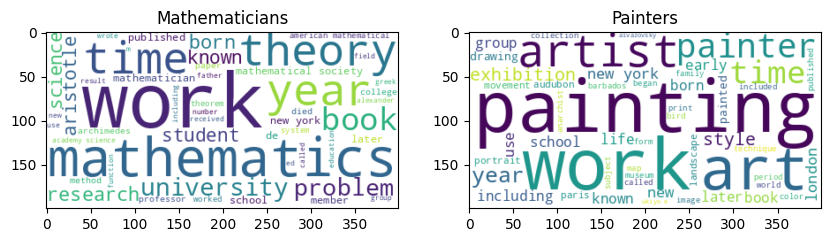

In [167]:
wc1 = WordCloud(background_color = 'white', max_words = 50).generate(math_norm_nostop_txt)
wc2 = WordCloud(background_color = 'white', max_words = 50).generate(paint_norm_nostop_txt)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(wc1, interpolation="bilinear")
ax1.title.set_text('Mathematicians')
ax2.imshow(wc2, interpolation="bilinear")
ax2.title.set_text('Painters')

### Bonus

In [ ]:
# TODO: remove spaces and \n
# word frequency per category
# POS count per category
# NE count per category

### Most common postags per category

In [169]:
# Most common verb
def pos_tag(row, ignore=True):
    pos_count = []
    for sent in row.sents:
        c = Counter(token.pos_ for token in sent if (not ignore and not token.pos_ in ("PROPN","PUNCT")) or ignore)
        pos_count.append(c)
    return sum(tuple(pos_count), Counter())

def named_entity(row):
    c = Counter(ne.label_ for ne in row.ents)
    return c

def ne_per_token(row):
    c = Counter((ne.text, ne.label_) for ne in row.ents)
    return c

In [170]:
df1["pos_tags"] = df1["nlp"].apply(pos_tag)
df1["ne"] = df1["nlp"].apply(named_entity)

In [171]:
df1["ne_token"] = df1["nlp"].apply(ne_per_token)

In [172]:
math_pos = sum(df1[df1["label"]==MATH_LABEL]["pos_tags"], Counter())
paint_pos = sum(df1[df1["label"]==PAINT_LABEL]["pos_tags"], Counter())

<BarContainer object of 10 artists>

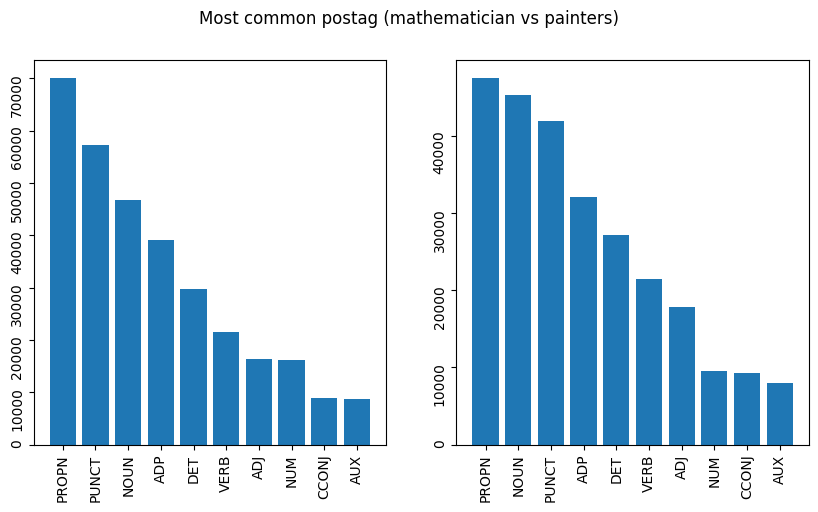

In [173]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common postag (mathematician vs painters)')
ax1.bar(*zip(*math_pos.most_common(10)))
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*paint_pos.most_common(10)))

In [174]:
math_ne = sum(df1[df1["label"]==MATH_LABEL]["ne"], Counter())
paint_ne = sum(df1[df1["label"]==PAINT_LABEL]["ne"], Counter())

<BarContainer object of 10 artists>

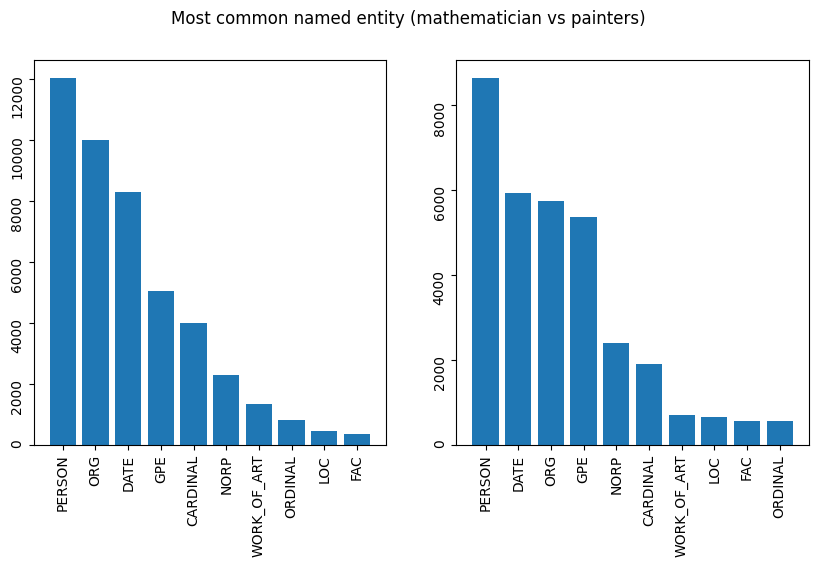

In [175]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common named entity (mathematician vs painters)')
ax1.bar(*zip(*math_ne.most_common(10)))
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*paint_ne.most_common(10)))

In [176]:
math_ne_token = sum(df1[df1["label"]==MATH_LABEL]["ne_token"], Counter())
paint_ne_token = sum(df1[df1["label"]==PAINT_LABEL]["ne_token"], Counter())

<BarContainer object of 10 artists>

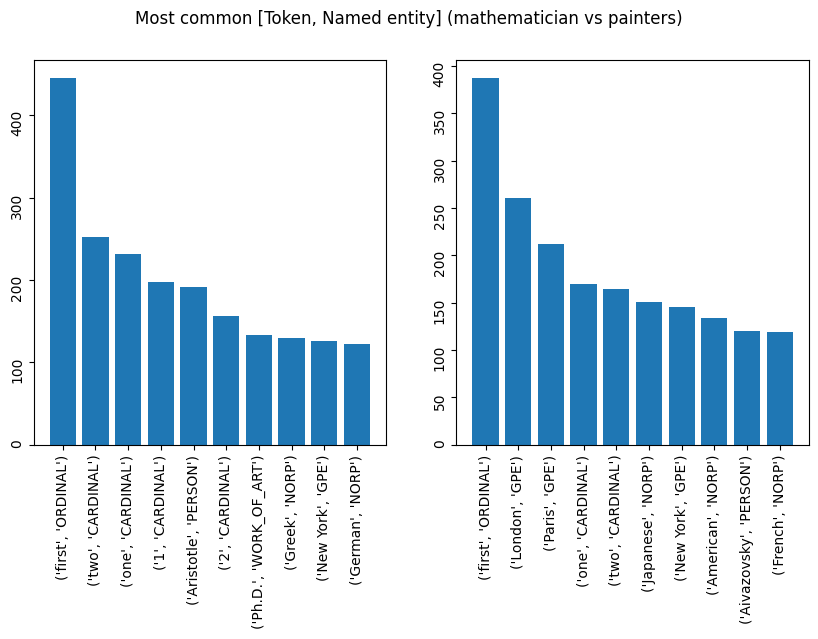

In [177]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Most common [Token, Named entity] (mathematician vs painters)')
ax1.bar(*zip(*[(str(ent[0]), ent[1]) for ent in math_ne_token.most_common(10)]))
ax1.tick_params(rotation=90)
ax2.tick_params(rotation=90)
ax2.bar(*zip(*[(str(ent[0]), ent[1]) for ent in paint_ne_token.most_common(10)]))